In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
from dds_loopback import DDSOverlay

In [2]:
ol = DDSOverlay(bitfile_name='hw/top_dac_feedthrough_dual_frontend_w_spi_trig_select.bit',dbg=True,plot=False,n_buffers=1,download=True)

loading bitfile hw/top_dac_feedthrough_dual_frontend_w_spi_trig_select.bit


measuring phase delay of frequency 1226MHz with reference 64MHz
setting vga attenuation to 18dB
setting cos_scale to 2 (12dB attenuation)
setting pinc to 262144 (6.400e+07Hz)
setting pinc to 5021696 (1.226e+09Hz)
n_intersect = [2143.9005853  1407.93166747]
t_intersect = [5.23413229e-07 3.43733317e-07]
coarse_delay_n = 735.9689178308154
fine_delay_n_crossover = 2775 = 693.75*4
fine_delay_n_correction = 710756 = 694.09765625*1024
phi = 0.3953173274191596 (22.650014429509138 deg)


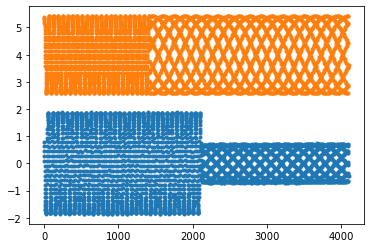

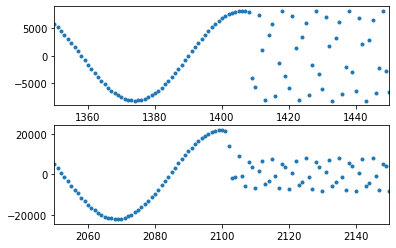

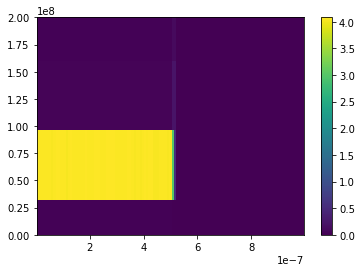

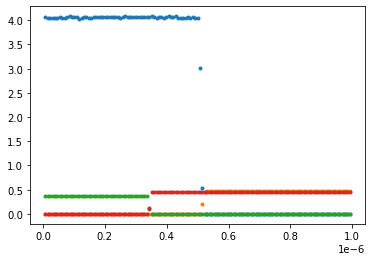

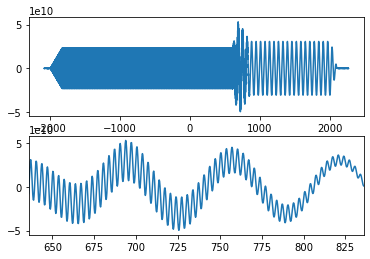

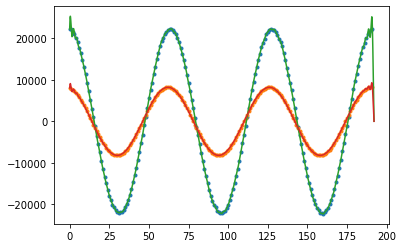

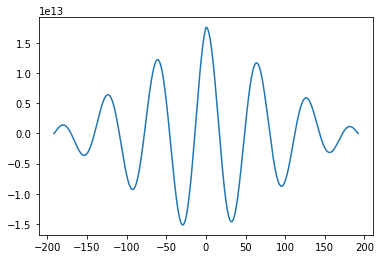

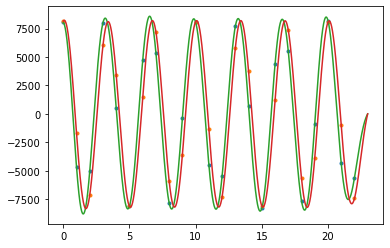

In [4]:
tones = np.array([64e6, 1226e6])
ol.dbg = True
ol.plot = True
OSR1 = 4
OSR2 = 1024
phi = ol.measure_phase(tones,OSR1,OSR2)

[ 54.1775376  100.99616793]


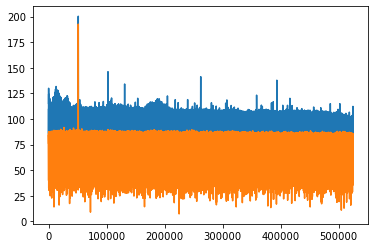

In [34]:
def sfdr_dBc(buffer, buffer_len=65536):
    fft = abs(np.fft.rfft(buffer, axis=0))[1:-1,:]
    fft.sort(axis=0)
    return 20*np.log10(fft[-1,:]/fft[-2,:])
print(sfdr_dBc(ol.dma_buffers[0]))

fft = 20*np.log10(abs(np.fft.rfft(ol.dma_buffers[0], axis=0)))[1:-1,:]
plt.plot(fft)

setting vga attenuation to 18dB
setting cos_scale to 2 (12dB attenuation)
setting pinc to 81920 (2.000e+07Hz)
transferred 4.0MiB in 106us (19.852GS/s)
setting pinc to 81928 (2.000e+07Hz)
transferred 4.0MiB in 100us (20.952GS/s)
setting pinc to 81936 (2.000e+07Hz)
transferred 4.0MiB in 100us (21.008GS/s)
setting pinc to 81944 (2.001e+07Hz)
transferred 4.0MiB in 99us (21.102GS/s)
setting pinc to 81952 (2.001e+07Hz)
transferred 4.0MiB in 98us (21.499GS/s)
setting pinc to 81960 (2.001e+07Hz)
transferred 4.0MiB in 99us (21.102GS/s)
setting pinc to 81969 (2.001e+07Hz)
transferred 4.0MiB in 100us (20.953GS/s)
setting pinc to 81977 (2.001e+07Hz)
transferred 4.0MiB in 100us (20.888GS/s)
setting pinc to 81985 (2.002e+07Hz)
transferred 4.0MiB in 98us (21.324GS/s)
setting pinc to 81993 (2.002e+07Hz)
transferred 4.0MiB in 101us (20.758GS/s)
setting pinc to 82001 (2.002e+07Hz)
transferred 4.0MiB in 99us (21.24GS/s)
setting pinc to 82010 (2.002e+07Hz)
transferred 4.0MiB in 98us (21.302GS/s)
setting p

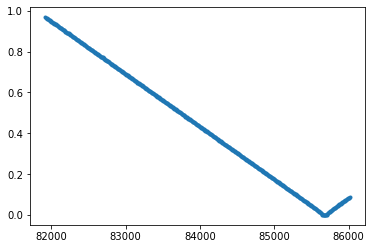

In [138]:
# calculate phase vs frequency
ol.plot = False

ol.set_vga_atten_dB(18)
ol.set_dac_atten_dB(12)
freqs = np.linspace(20e6, 21e6, 501)
phase = np.zeros(freqs.shape)
for i,freq in enumerate(freqs):
    ol.set_freq_hz(freq)
    ol.capture_data(ol.dma_buffers[0])
    N_samp = 16384
    raw = ol.dma_buffers[0][:N_samp,:]
    raw = (raw - np.mean(raw, axis=0))/np.std(raw, axis=0)
    c = np.cov(np.transpose(raw))
    phase[i] = np.arccos(np.clip(c[0,1],-1,1))
# calculate phase_offset_200MHz and phase_inc_per_hz
phase_incs = ((freqs/ol.f_samp)*(2**ol.phase_bits)).astype(np.uint32)
A = np.vstack([phase_incs, np.ones(len(phase_incs))]).T
phase_inc_per_pinc_20MHz, phase_offset_pinc_20MHz = np.linalg.lstsq(A, phase, rcond=None)[0]
phase_offset_pinc_20MHz += phase_inc_per_pinc_20MHz*int((20e6/ol.f_samp)*(2**ol.phase_bits))
print(phase_inc_per_pinc_20MHz*2**24, phase_offset_pinc_20MHz)
plt.plot(phase_incs, phase, '.')

In [206]:
print(phase_inc_per_pinc_20MHz*2**24, phase_offset_pinc_20MHz)

-4157.475619017378 0.9547335876903951


setting pinc to 831488 (2.030e+08Hz)
setting vga attenuation to 18dB
setting cos_scale to 2 (12dB attenuation)
transferred 4.0MiB in 113us (18.622GS/s)


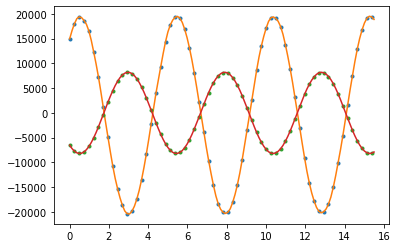

In [47]:
ol.plot = True
ol.set_freq_hz(203e6)
ol.set_vga_atten_dB(18)
ol.set_dac_atten_dB(12)
ol.capture_data(ol.dma_buffers[0], N_samp=64, OSR=2)

setting pinc to 819200 (2.000e+08Hz)
setting vga attenuation to 0dB
b'read attenuation back: 0dB\r\n'
b'Invalid character; please input attenuation in dB (as a 2-digit decimal) and press ENTER\r\n'
b'setting attenuation to 12dB\r\n'
b'read attenuation back: 0dB\r\n'
b'0\r\n'
b'setting attenuation to 0dB\r\n'
setting cos_scale to 0 (0dB attenuation)
transferred 4.0MiB in 118us (17.718GS/s)


NameError: name 'sfdr_dBc' is not defined

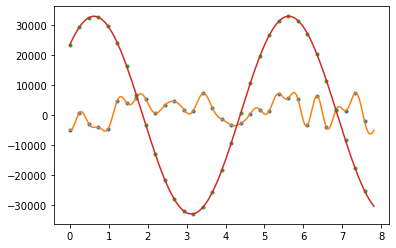

In [13]:
ol.set_freq_hz(200e6)
sfdr = np.zeros((33,11))
vga_atten_settings = np.linspace(0,32,33)
dac_atten_settings = np.linspace(0,60,11)
for v,vga_atten in enumerate(vga_atten_settings):
    ol.set_vga_atten_dB(vga_atten)
    for d,dac_atten in enumerate(dac_atten_settings):
        ol.set_dac_atten_dB(dac_atten)
        ol.capture_data(ol.dma_buffers[0], N_samp=32, OSR=1024)
        sfdr[v,d] = sfdr_dBc(ol.dma_buffers[0])
        print(f'for vga_atten = {vga_atten}, dac_atten = {dac_atten}, got SFDR = {sfdr[v,d]}')

In [62]:
scipy.io.savemat('data/afe_loopback_dac_sfdr_200MHz.mat', {'vga_atten': vga_atten_settings, 'dac_atten': dac_atten_settings, 'sfdr': sfdr, 'freq': 1.4e9})

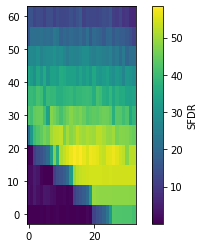

In [64]:
#plt.imshow(sfdr, interpolation=None, origin='lower', extent=[-3, 63, 0, 32])
v,d = np.meshgrid(vga_atten_settings, dac_atten_settings)
plt.pcolor(v, d, np.transpose(sfdr))
cb=plt.colorbar()
cb.set_label('SFDR')
plt.gca().set_aspect('equal')

In [9]:
fft = 20*np.log10(abs(np.fft.rfft(ol.dma_buffers[0])))-20*np.log10(ol.dma_frame_size*(2**16))

/tmp/ipykernel_14742/727962273.py:1: RuntimeWarning: divide by zero encountered in log10
  fft = 20*np.log10(abs(np.fft.rfft(ol.dma_buffers[0])))-20*np.log10(ol.dma_frame_size*(2**16))


[-30.32266976967722, -84.45834857261463, -92.64246328227352, -93.48622157603435, -93.65850278301221]
54.135678802937406


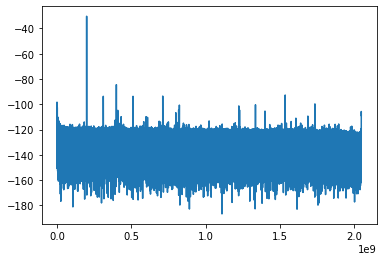

In [4]:
fft = 20*np.log10(abs(np.fft.rfft(ol.dma_buffers[0])))-20*np.log10(ol.dma_frame_size*(2**16))
fvec = np.linspace(0,ol.f_samp/2,ol.dma_frame_size//2+1,endpoint=True)
plt.plot(fvec[1:-1],fft[1:-1])
#plt.xlim([2.048e9-2e6, 2.048e9+2e6])
peaks = sorted(fft[1:-1], reverse=True)[:5]
print(peaks)
print(peaks[0] - peaks[1])

In [3]:
vga_setting = 0
for scale in [0, 6, 12, 30, 60]:
    ol.do_freq_sweep(f"data/afe_loopback_dac_{scale}dB_vga_{vga_setting}dB.mat", scale, np.logspace(4, 9.25, 200))

setting cos_scale to 0 (0dB attenuation)
setting pinc to 40 (1.000e+04Hz)
transferred 4.0MiB in 110us (19.086GS/s)
setting pinc to 43 (1.063e+04Hz)
transferred 4.0MiB in 90us (23.265GS/s)
setting pinc to 46 (1.129e+04Hz)
transferred 4.0MiB in 82us (25.591GS/s)
setting pinc to 49 (1.200e+04Hz)
transferred 4.0MiB in 81us (25.749GS/s)
setting pinc to 52 (1.275e+04Hz)
transferred 4.0MiB in 81us (25.818GS/s)
setting pinc to 55 (1.355e+04Hz)
transferred 4.0MiB in 82us (25.596GS/s)
setting pinc to 58 (1.440e+04Hz)
transferred 4.0MiB in 81us (25.833GS/s)
setting pinc to 62 (1.530e+04Hz)
transferred 4.0MiB in 82us (25.73GS/s)
setting pinc to 66 (1.626e+04Hz)
transferred 4.0MiB in 81us (25.884GS/s)
setting pinc to 70 (1.728e+04Hz)
transferred 4.0MiB in 82us (25.61GS/s)
setting pinc to 75 (1.836e+04Hz)
transferred 4.0MiB in 84us (24.978GS/s)
setting pinc to 79 (1.951e+04Hz)
transferred 4.0MiB in 82us (25.492GS/s)
setting pinc to 84 (2.073e+04Hz)
transferred 4.0MiB in 82us (25.612GS/s)
setting pin